In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.metrics import mean_absolute_error as mae
from pandas.tseries.offsets import BDay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [4]:
df_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Stock Market/TESLA.csv')
df_main.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-16,45.098000,45.438000,44.681999,44.722000,44.722000,11335500
1,2016-08-17,44.866001,44.966000,44.560001,44.647999,44.647999,8935500
2,2016-08-18,44.764000,45.132000,44.458000,44.702000,44.702000,8572500
3,2016-08-19,44.708000,45.034000,44.506001,45.000000,45.000000,8297500
4,2016-08-22,44.834000,45.021999,44.535999,44.585999,44.585999,10327500


In [4]:
df_main.shape

(1258, 7)

In [5]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [5]:
time = pd.date_range(start='16/08/2016',periods=1258,freq=BDay())
df_main['time_stamp'] = pd.DataFrame(time)
df_main.drop(['Date'],axis=1,inplace=True)
df_main = df_main.set_index('time_stamp')

In [6]:
df = df_main[['Close']]

In [8]:
df.head()

,Close
time_stamp,
2016-08-16,44.722000
2016-08-17,44.647999
2016-08-18,44.702000
2016-08-19,45.000000
2016-08-22,44.585999


In [9]:
df.tail()

,Close
time_stamp,
2021-06-04,713.760010
2021-06-07,709.989990
2021-06-08,707.820007
2021-06-09,722.250000
2021-06-10,717.169983


In [7]:
plt.rcParams['figure.figsize'] = [15,8]

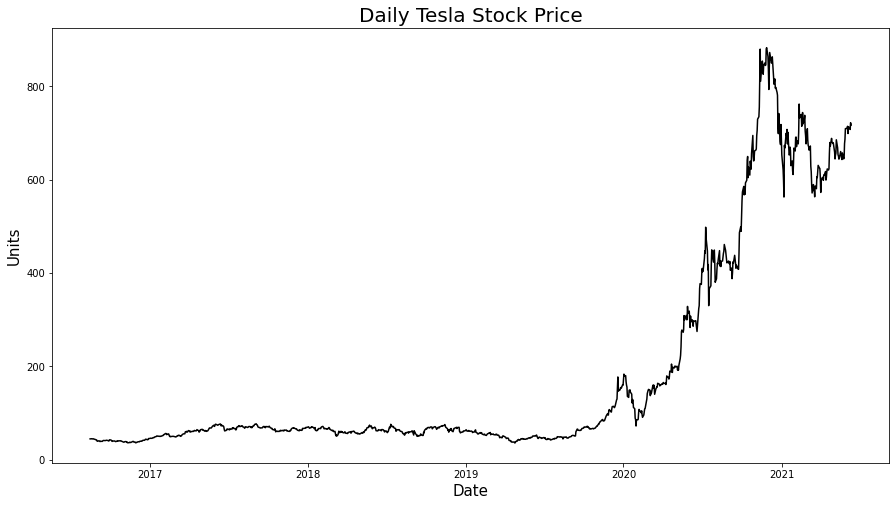

In [8]:
plt.plot(df,color='black')
plt.title('Daily Tesla Stock Price',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [9]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [10]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['Close'] = df['Close'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [11]:
#Split data set into testing dataset and train dataset
train_size = 1132
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 4
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1128, 4)
(1128,)
(122, 4)
(122,)


In [17]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [14]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [20]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 7)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [25]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_3')

In [26]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 19 Complete [00h 00m 41s]
val_mape: 11.363399505615234

Best val_mape So Far: 2.2941291332244873
Total elapsed time: 00h 10m 25s

Search: Running Trial #20

Hyperparameter    |Value             |Best Value So Far 
num_layers        |6                 |5                 
units_0           |96                |40                
dropout           |True              |False             
learning_rate     |8.9422e-05        |3.4148e-05        
Dropout_rate      |0.3               |0.3               
units_1           |184               |224               
units_2           |232               |224               
units_3           |136               |224               
units_4           |208               |224               
units_5           |40                |72                

Epoch 1/200
34/34 [==============================] - 1s 10ms/step - loss: 58.3269 - mape: 58.3269 - val_loss: 50.0991 - val_mape: 50.0991
Epoch 2/200
34/34 [==============================] - 0s 6ms/step - loss

In [28]:
tuner.results_summary()

Results summary
Results in project/loa_em_3
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
num_layers: 5
units_0: 40
dropout: False
learning_rate: 3.4147781125158124e-05
Dropout_rate: 0.30000000000000004
units_1: 224
units_2: 224
units_3: 224
units_4: 224
units_5: 72
Score: 2.2941291332244873
Trial summary
Hyperparameters:
num_layers: 6
units_0: 232
dropout: False
learning_rate: 0.0003268541179449287
Dropout_rate: 0.2
units_1: 48
units_2: 240
units_3: 232
units_4: 80
units_5: 128
Score: 2.2978296279907227
Trial summary
Hyperparameters:
num_layers: 4
units_0: 136
dropout: False
learning_rate: 3.543931925231717e-05
Dropout_rate: 0.2
units_1: 224
units_2: 200
units_3: 88
units_4: 104
units_5: 112
Score: 2.2980947494506836
Trial summary
Hyperparameters:
num_layers: 1
units_0: 24
dropout: False
learning_rate: 0.0019288000735763592
Dropout_rate: 0.30000000000000004
units_1: 8
units_2: 16
units_3: 176
units_4: 192
units_5: 136
Score: 2.299680

In [29]:
from warnings import filterwarnings
filterwarnings('ignore')

In [30]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 4))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                200       
                                                                 
 dense_1 (Dense)             (None, 224)               9184      
                                                                 
 dense_2 (Dense)             (None, 224)               50400     
                                                                 
 dense_3 (Dense)             (None, 224)               50400     
                                                                 
 dense_4 (Dense)             (None, 224)               50400     
                                                                 
 dense_5 (Dense)             (None, 1)                 225       
                                                                 
Total params: 160,809
Trainable params: 160,809
Non-trai

In [12]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
model = Sequential()
model.add(Dense(256,activation='relu',input_dim = 4))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 3.4147781125158124e-05)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 300)

Epoch 1/300
34/34 [==============================] - 39s 8ms/step - loss: 76.1129 - mape: 76.1129 - val_loss: 67.4528 - val_mape: 67.4528
Epoch 2/300
34/34 [==============================] - 0s 3ms/step - loss: 45.9853 - mape: 45.9853 - val_loss: 47.0017 - val_mape: 47.0017
Epoch 3/300
34/34 [==============================] - 0s 4ms/step - loss: 19.8077 - mape: 19.8077 - val_loss: 29.7057 - val_mape: 29.7057
Epoch 4/300
34/34 [==============================] - 0s 3ms/step - loss: 13.7374 - mape: 13.7374 - val_loss: 27.0751 - val_mape: 27.0751
Epoch 5/300
34/34 [==============================] - 0s 4ms/step - loss: 13.2569 - mape: 13.2569 - val_loss: 25.9007 - val_mape: 25.9007
Epoch 6/300
34/34 [==============================] - 0s 4ms/step - loss: 12.9562 - mape: 12.9562 - val_loss: 25.1603 - val_mape: 25.1603
Epoch 7/300
34/34 [==============================] - 0s 4ms/step - loss: 12.5025 - mape: 12.5025 - val_loss: 22.6668 - val_mape: 22.6668
Epoch 8/300
34/34 [=====================

In [18]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [19]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.74 
Test MAPE : 2.34 


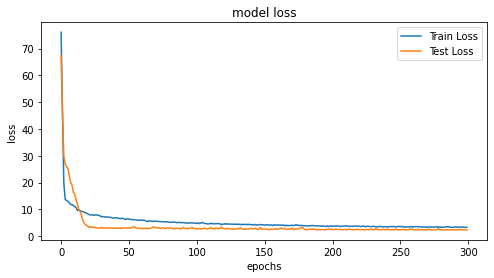

In [20]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [23]:
import seaborn as sns

In [21]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(1128,1250)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

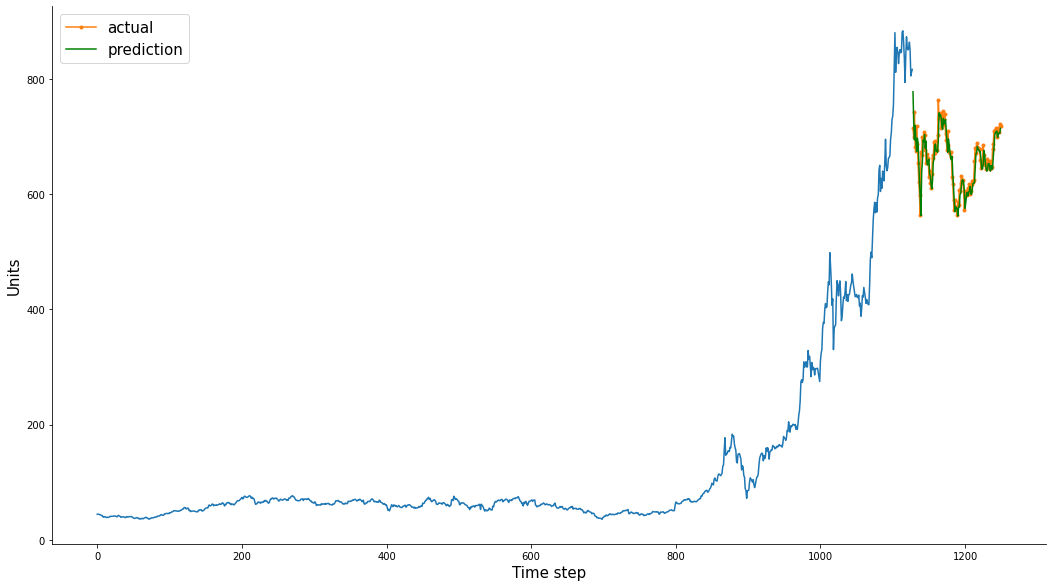

In [24]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)